In [1]:
# magic notebook options
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import callbacks

from nn.model import DETR
from misc.losses import MatchLoss
from misc.data_loader import generator

In [3]:
path_to_train = r'kangaroo/train'
path_to_val   = r'kangaroo/validation'
num_classes  = 1
max_detections = 10
num_encoder_layers = 6
num_decoder_layers = 6
batch_size = 2
img_size = (300,300)

In [4]:
model = DETR(num_classes=num_classes,
             max_detections=max_detections,
             num_encoder_layers=num_encoder_layers,
             num_decoder_layers=num_decoder_layers,
             backbone='resnet50')

In [5]:
model.compile(tfa.optimizers.AdamW(weight_decay=1e-4, learning_rate=1e-4, clipvalue=0.1),
              MatchLoss(num_classes))

In [6]:
model.fit(
    generator(batch_size, path_to_train, num_classes, max_detections, num_decoder_layers, img_size),
    steps_per_epoch = 114//batch_size,
    epochs = 100,
    
    validation_data=generator(batch_size, path_to_val, num_classes, max_detections, 1, img_size),
    validation_steps=50//batch_size,
    
    callbacks=[callbacks.TerminateOnNaN(),
               callbacks.ModelCheckpoint(f'detr.h5',
                                         monitor='val_loss', mode='min',
                                         verbose=1, save_best_only=True),
               callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,
                                       mode='min', restore_best_weights=True),
               callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                                           verbose=1, mode='min', min_lr=1e-6),
               callbacks.CSVLogger(f'detr_history.csv')]
)


Epoch 1/100
56/57 [============================>.] - ETA: 1s - class_loss: 0.1602 - boxes_loss: 0.1968 - loss: 0.1785
Validation 1/100
24/25 [===========================>..] - ETA: 0s - val_class_loss: 0.1720 - val_boxes_loss: 0.1775 - val_loss: 0.1747
Epoch 00002: val_loss improved from inf to 0.17473, saving model to detr.h5


Epoch 2/100
56/57 [============================>.] - ETA: 1s - class_loss: 0.1572 - boxes_loss: 0.1855 - loss: 0.1714
Validation 2/100
24/25 [===========================>..] - ETA: 0s - val_class_loss: 0.1024 - val_boxes_loss: 0.1663 - val_loss: 0.1343
Epoch 00003: val_loss improved from 0.17473 to 0.13434, saving model to detr.h5


Epoch 3/100
56/57 [============================>.] - ETA: 1s - class_loss: 0.1383 - boxes_loss: 0.1807 - loss: 0.1595
Validation 3/100
24/25 [===========================>..] - ETA: 0s - val_class_loss: 0.0718 - val_boxes_loss: 0.1659 - val_loss: 0.1188
Epoch 00004: val_loss improved from 0.13434 to 0.11883, saving model to detr.h5


In [7]:
def cxcy_to_xy(boxes):
    # get boxes in cx,cy,w,h
    cx = boxes[...,0]
    cy = boxes[...,1]
    w  = boxes[...,2]
    h  = boxes[...,3]
    
    # convert to xmin, ymin, xmax, ymax
    xmin = cx - w/2
    ymin = cy - h/2
    xmax = cx + w/2
    ymax = cy + h/2
    
    boxes =  np.stack([xmin, ymin, xmax, ymax], axis=-1)
    return np.clip(boxes, 0, 1)

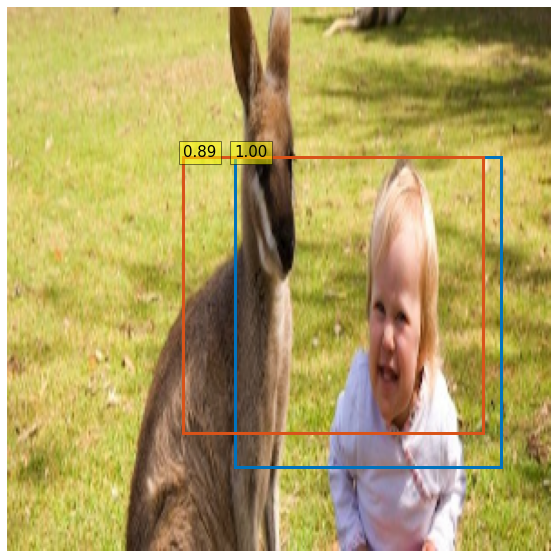

In [13]:
import numpy as np
import matplotlib.pyplot as plt

img, labels = next(generator(1, path_to_val, num_classes, max_detections, 1, img_size))

scores, boxes = model(img, training=False)
scores = scores.numpy()
boxes  = boxes.numpy()

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

keep = scores[0][:,0]<0.5

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

im = np.uint8((img[0]+1.)*127.5)
plot_results(im[0], scores[0][keep], cxcy_to_xy(boxes[0][keep])*300)